In [1]:
import torch
import spacy
import pandas as pd
import nltk

In [2]:
# Dataset
SA_dataset = pd.read_csv('SA_dataset.csv')

In [3]:
SA_dataset

,Review,Rating,Sentiment
0,**Possible Spoilers**,1,0
1,"Read the book, forget the movie!",2,0
2,**Possible Spoilers Ahead**,2,0
3,"What a script, what a story, what a mess!",2,0
4,I hope this group of film-makers never re-unites.,1,0
...,...,...,...
4995,"I have only seen this once--in 1986, at an ""ar...",10,1
4996,"This being my first John Carpenter film, I mus...",9,1
4997,"This is kind of a weird movie, given that Sant...",1,0
4998,"Vic (Richard Dreyfuss) is a mob boss, leaving ...",4,0


In [11]:
freq_dist = SA_dataset['Review'].str.split(expand=True).unstack().dropna()
freq_dist.value_counts()

the          13513
a             8698
and           8157
of            7334
is            6567
             ...  
tribute)         1
Rowlands,        1
Dark"...         1
temple           1
wildness.        1
Length: 36703, dtype: int64

In [7]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
from nltk.corpus import stopwords
from collections import Counter

swords = stopwords.words('english')
freq_dist = Counter({word:count for word, count in freq_dist.value_counts().items()
                     if word.lower() not in swords})

In [13]:
freq_dist.most_common(10)

[('movie', 3349),
 ('film', 1862),
 ('one', 1516),
 ('like', 1070),
 ('good', 1056),
 ('see', 849),
 ('great', 832),
 ('really', 774),
 ('movie.', 702),
 ('story', 688)]

In [14]:
freq_dist

Counter({'movie': 3349,
         'film': 1862,
         'one': 1516,
         'like': 1070,
         'good': 1056,
         'see': 849,
         'great': 832,
         'really': 774,
         'movie.': 702,
         'story': 688,
         'bad': 643,
         'it.': 618,
         'even': 611,
         'ever': 610,
         'would': 597,
         'best': 528,
         'movies': 510,
         'time': 498,
         'watch': 497,
         'seen': 495,
         'acting': 491,
         'film.': 468,
         'much': 466,
         'think': 451,
         'make': 450,
         'made': 448,
         'get': 445,
         'could': 442,
         'plot': 434,
         'love': 420,
         '-': 419,
         'first': 415,
         'well': 383,
         'never': 365,
         'people': 360,
         'movie,': 353,
         'worst': 345,
         'better': 343,
         'little': 337,
         'saw': 311,
         'characters': 309,
         'still': 297,
         "I've": 296,
         'worth': 296,
 

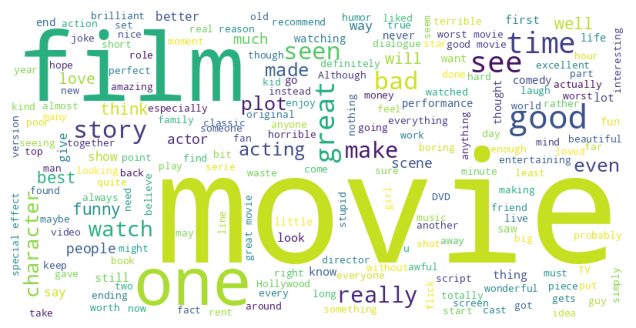

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          background_color='white'
                          ).generate(text)

    fig = plt.figure(1, figsize=(8, 4))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig("WordCloud.png")

text = " ".join(SA_dataset['Review'].values)
generate_wordcloud(text)

## WORKING WITH SPACY

In [19]:
# Loading the model
model = spacy.load('en_core_web_md')

OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a Python package or a valid path to a data directory.

In [20]:
# Add the pipe
textcat = model.add_pipe('textcat', last=True)

NameError: name 'model' is not defined

In [ ]:
from spacy.training import Example

In [ ]:
input = Example.from_dict(model.make_doc('This is a test'), {'cats': {'POSITIVE': 1.0, 'NEGATIVE': 0.0}})


In [ ]:
textcat.initialize(lambda: [input], nlp=model)

In [ ]:
# Create the optimizer
optimizer = model.resume_training()

In [21]:
# Training the model
from sklearn.model_selection import train_test_split

X = SA_dataset['Review'].values
y = SA_dataset['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the model
from spacy.training import Example

def create_examples(X, y):
    examples = []
    for text, label in zip(X, y):
        doc = model.make_doc(text)
        examples.append(Example.from_dict(doc, {'cats': {'POSITIVE': int(label), 'NEGATIVE': int(not label)}}))
    return examples

train_examples = create_examples(X_train, y_train)
test_examples = create_examples(X_test, y_test)

In [ ]:
# Let's train the model
from spacy.training import Example

n_iter = 2
for i in range(n_iter):
    losses = {}
    model.update(train_examples, losses=losses, drop=0.0, sgd=optimizer)
    print(losses)

{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.14842896163463593}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.13713231682777405}


In [ ]:
model(test_examples[0].reference).cats

{'POSITIVE': 0.6279250979423523, 'NEGATIVE': 0.3720749318599701}

In [ ]:
# Testing the model

def evaluate_model(examples, y_test):
    correct = 0
    total = 0
    results = []
    for example, y in zip(examples, y_test):
        doc = example.reference
        prediction = model(doc)
        if prediction.cats['POSITIVE'] > prediction.cats['NEGATIVE']:
            prediction = 1
        else:
            prediction = 0
        if prediction == y:
            correct += 1
        total += 1
        results.append(prediction)
    return correct / total, results

accuracy, results = evaluate_model(test_examples, y_test)

In [ ]:
print("Accuracy: ", accuracy)
from sklearn.metrics import classification_report

print(classification_report(y_test, results))

Accuracy:  0.736
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       464
           1       0.81      0.66      0.73       536

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



## LSTM

In [16]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

In [22]:
vocabulary = ['<PAD>'] + sorted(list({word for sentence in X for word in sentence.split()}))
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocabsize = len(vocabulary)

In [25]:
# Define the loader
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        return self.X[index], self.y[index]

def collate(batch):
    x, y = map(list, zip(*batch))
    x = [torch.tensor(seq) for seq in x]
    y = torch.tensor(y)
    padded_batch = pad_sequence(x, batch_first=True, padding_value=0)
    return padded_batch, y

X_train_idx = [[word2idx[word] for word in sentence.split()] for sentence in X_train]
X_test_idx = [[word2idx[word] for word in sentence.split()] for sentence in X_test]

train_dataset = SentimentDataset(X_train_idx, y_train)
test_dataset = SentimentDataset(X_test_idx, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate)


In [24]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, size_embedding, hidden_dim, output_dim, bidirectional):
        super(SentimentClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, size_embedding)
        self.rnn = nn.LSTM(size_embedding, hidden_dim, batch_first = True, bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_dim , output_dim)
        self.numb_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        self.dropout = nn.Dropout(0.2)
        self.bidirectional = bidirectional
        print("Model initialized")
        print("Number of parameters: ", self.numb_parameters)

    def forward(self, batch_sentences):
        embeddings = self.word_embeddings(batch_sentences)
        output, (hidden, cell) = self.rnn(embeddings)
        if self.bidirectional:
          hidden.sum(dim=0)
          out = self.dropout(self.fc(hidden.sum(dim=0)))
        else:
          out = self.dropout(self.fc(hidden.squeeze(0)))
        return out

# Define the model

model = SentimentClassifier(vocabsize,
                            size_embedding = 300,
                            hidden_dim = 100,
                            output_dim = 2,
                            bidirectional = True)

model.to('cuda' if torch.cuda.is_available() else 'cpu')

Model initialized
Number of parameters:  11333002


SentimentClassifier(
  (word_embeddings): Embedding(36704, 300)
  (rnn): LSTM(300, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [123]:
class SentimentClassifier2(nn.Module):
    def __init__(self, vocab_size, size_embedding, hidden_dim, output_dim, bidirectional, num_layers=1):
        super(SentimentClassifier2, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, size_embedding)
        self.rnn = nn.LSTM(size_embedding, hidden_dim, batch_first = True, bidirectional = bidirectional, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, int(hidden_dim/2)),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/2), output_dim)
        )
        self.numb_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        self.dropout = nn.Dropout(0.3)
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.fc_bi = nn.Linear(hidden_dim*2, hidden_dim)
        print("Model initialized")
        print("Number of parameters: ", self.numb_parameters)
        self.num_layers = num_layers

    def forward(self, batch_sentences):
        embeddings = self.word_embeddings(batch_sentences)
        output, (hidden, cell) = self.rnn(embeddings)
        if self.bidirectional:
          hidden = hidden.view(self.num_layers, 2, batch_sentences.size(0), -1)
          hidden = hidden[-1, :, : , :]
          hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
          hidden = self.fc_bi(hidden)
          out = self.fc(self.dropout(hidden))
        else:
          out = self.fc(self.dropout(hidden.squeeze(0)))
        return out

# Define the model

model = SentimentClassifier2(vocabsize,
                            size_embedding = 300,
                            hidden_dim = 200,
                            output_dim = 2,
                            bidirectional = True,
                            num_layers=2)

model.to('cuda' if torch.cuda.is_available() else 'cpu')

Model initialized
Number of parameters:  12797902


SentimentClassifier2(
  (word_embeddings): Embedding(36704, 300)
  (rnn): LSTM(300, 200, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_bi): Linear(in_features=400, out_features=200, bias=True)
)

In [124]:
def test(model, test_loader):
    model.eval()
    # Test set in order to use classification_report
    y_test = []
    results = []
    for batch, sentiment in test_loader:
        batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        output = model(batch)
        # Get the max prediction
        _, prediction = torch.max(output, 1)
        results.append(prediction.detach().cpu())
        y_test.append(sentiment)

    results = torch.cat(results)
    y_test = torch.cat(y_test)
    return results, y_test


def train(model, train_loader, criterion, optimizer, n_epochs):
    model.train()
    squeduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)
    for epoch in range(n_epochs):
        for batch, y_train in train_loader:
            batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
            y_train = y_train.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()
        squeduler.step()
        print(f"Epoch {epoch + 1} / {n_epochs}, Loss: {loss.item()}")

    return model

In [125]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model = train(model, train_loader=train_loader,
      criterion=criterion,
      optimizer=optimizer,
      n_epochs=30)

Epoch 1 / 30, Loss: 0.633999764919281
Epoch 2 / 30, Loss: 0.429211288690567
Epoch 3 / 30, Loss: 0.28983572125434875
Epoch 4 / 30, Loss: 0.2658831477165222
Epoch 5 / 30, Loss: 0.15342456102371216
Epoch 6 / 30, Loss: 0.046508293598890305
Epoch 7 / 30, Loss: 0.0010456191375851631
Epoch 8 / 30, Loss: 0.0014411583542823792
Epoch 9 / 30, Loss: 0.0008786514517851174
Epoch 10 / 30, Loss: 0.0003872991946991533
Epoch 11 / 30, Loss: 0.0008921934058889747
Epoch 12 / 30, Loss: 0.0010920673375949264
Epoch 13 / 30, Loss: 0.0011716721346601844
Epoch 14 / 30, Loss: 0.001626787823624909
Epoch 15 / 30, Loss: 0.0006344062858261168
Epoch 16 / 30, Loss: 0.0016331624938175082
Epoch 17 / 30, Loss: 0.0005436364444904029
Epoch 18 / 30, Loss: 0.0011607714695855975
Epoch 19 / 30, Loss: 0.0003603558870963752
Epoch 20 / 30, Loss: 0.0004610646574292332
Epoch 21 / 30, Loss: 0.0003565983206499368
Epoch 22 / 30, Loss: 0.001096176914870739
Epoch 23 / 30, Loss: 0.0009482623427174985
Epoch 24 / 30, Loss: 0.000690153799951

In [126]:
from sklearn.metrics import classification_report
results, y_test = test(model, test_loader)

In [127]:
print(classification_report(results, y_test))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       444
           1       0.83      0.80      0.82       556

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



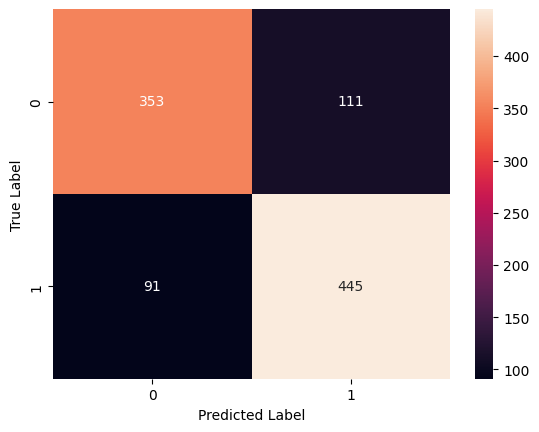

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test.cpu().numpy(),
                               results.cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()